<h1 style="text-align: center; font-family: 'Arial', sans-serif; color: #2c3e50;">
  <strong>Operator Learning with DeepONets: Solving Parametric Differential Equations</strong>
</h1>

<hr style="border: 1px solid #2c3e50; width: 80%; margin: auto;">

<p style="text-align: center; font-family: 'Arial', sans-serif; color: #34495e; font-size: 18px;">
  This notebook introduces Deep Operator Networks (DeepONets) as a powerful framework for learning mappings between function spaces. We demonstrate how to apply DeepONets to solve different ODEs systems.
</p>

<p style="text-align: center; font-family: 'Arial', sans-serif; color: #34495e; font-size: 18px;">
  <strong>Authors</strong><br>
  PhD student Lucas Tesan<br>
  PhD student Mikel Martinez
</p>

**Reference Paper:** DeepONet: Learning nonlinear operators for identifying differential equations based on the universal approximation theorem of operators.
*Lu Lu, Pengzhan Jin, George Em Karniadakis* \\
https://arxiv.org/abs/1910.03193



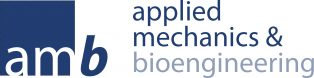

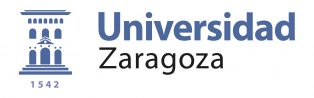

# 🌟 DeepONets-Lightning Setup  
### 🛠️ *Environment Configuration & Repository Installation*  

**GitHub Repository:** [LucasUnizar/DeepONets-Lightning](https://github.com/LucasUnizar/DeepONets-Lightning)  

---

This section handles all the groundwork—cloning the GitHub repository, installing required libraries, and configuring the environment—so your notebook runs smoothly. Simply execute the cells below to get everything ready!



In [12]:
# GitHub Repository Download
REPO_URL = "https://github.com/LucasUnizar/DeepONets-Lightning"
print(f"📦 Cloning repository from: {REPO_URL}")

!git clone {REPO_URL} --quiet
%cd DeepONets-Lightning/

📦 Cloning repository from: https://github.com/LucasUnizar/DeepONets-Lightning
/content/DeepONets-Lightning/DeepONets-Lightning


In [13]:
# 🧰 Dependency Installation
print("\n⚙️ Installing required packages...")
!pip install -r requirements.txt --quiet


⚙️ Installing required packages...


# 🚀 **DeepONets Mastery**  
### ⚡ *From Setup to Execution*  
▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰  

**Learn to code** cutting-edge DeepONets architectures with  
this hands-on guide. Clone, configure, and run—**all in one place!**

🏗️ **Building Your DeepONet**: \\
Your Challenge: Improve the results!

In [15]:
from src.dataset.dataset import DataModule
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

In [25]:
# Setup prebuild data loading module

# Path to the MATLAB data file containing reaction-diffusion simulation data
database = 'data/Jaca25/Burgers-tester.mat'

# Create a DataModule instance
data_module = DataModule(
    mat_file_path=database,
    batch_size=512
)

# Setup the data module for the 'fit' phase (training)
# This will:
# 1. Load and parse the .mat file
# 2. Split the data into training and validation sets
# 3. Prepare the data loaders
data_module.setup('fit')


Initializing DataModule with batch_size: 512, sampled: 100

Setting up DataModule for stage: fit

Loading data from data/Jaca25/Burgers-tester.mat for train split
Available keys in .mat file: ['__header__', '__version__', '__globals__', 'Nt_sample', 'nu', 's_train', 't_sampled', 't_solver', 'u_train', 'x', 'y_train']

Original shapes before reshaping:
u_train shape: torch.Size([10000, 256]) (input functions)
y_train shape: torch.Size([10000, 2]) (coordinates)
s_train shape: torch.Size([10000, 1]) (solutions)

After reshaping to [Trajectories, Sampled, Features]:
u_train shape: torch.Size([100, 100, 256])
y_train shape: torch.Size([100, 100, 2])
s_train shape: torch.Size([100, 100, 1])

After selecting train split (80 trajectories):
u_train shape: torch.Size([80, 100, 256])
y_train shape: torch.Size([80, 100, 2])
s_train shape: torch.Size([80, 100, 1])

Final flattened shapes for train dataset:
Input functions (u) shape: torch.Size([8000, 256])
Coordinates (y) shape: torch.Size([8000, 

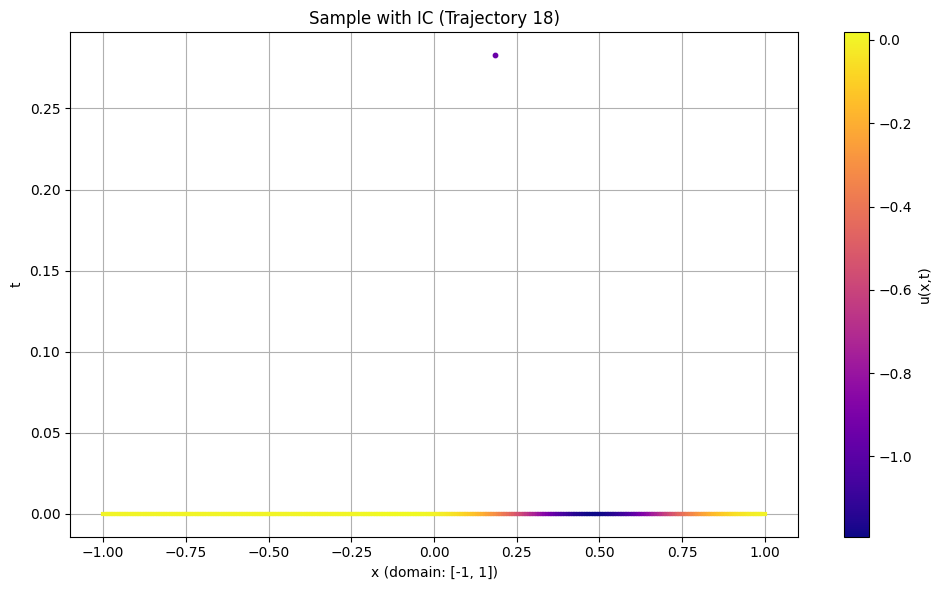

In [26]:
domain = [-1,1]
data_module.plot_solution_with_ic(trajectory_idx=18, input_domain=domain)

In [27]:
# Setup trainer module with PyTorch Lightning
trainer = pl.Trainer(
    # Automatically select the best accelerator available (GPU, TPU, CPU)
    accelerator='auto',

    # Automatically use all available devices (GPUs/TPUs)
    devices='auto',

    # Show progress bar during training
    enable_progress_bar=True,

    # Disable validation sanity checks before starting training
    # (0 means skip the initial validation check)
    num_sanity_val_steps=0,

    # Log control
    log_every_n_steps=1,

    # Show model summary before training starts
    enable_model_summary=True,

    # Max number of epochs (hyperparam)
    max_epochs=300
)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [28]:
import torch
import numpy as np
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import wandb


class DeepONet_custom(pl.LightningModule):
    def __init__(self, m=100, P=100, hidden_dim=128, trunk_layers=3, branch_layers=3, domain=[-1,1], time=[0,1]):
        """
        Args:
            m: Number of input function sensors
            P: Number of evaluation points
            hidden_dim: Dimension of hidden layers
            trunk_layers: Number of layers in trunk network (minimum 1)
            branch_layers: Number of layers in branch network (minimum 1)
        """
        super().__init__()
        self.save_hyperparameters()
        # External arguments
        self.domain = domain
        self.time_domain = time

        # Validate layer counts
        if trunk_layers < 1 or branch_layers < 1:
            raise ValueError("Both trunk_layers and branch_layers must be at least 1")

        # Activation Function
        ##########################################################################################################
        self.activation = nn.Tanh()
        ##########################################################################################################

        # Branch net (processes input function)
        branch_modules = []
        in_features = m
        for i in range(branch_layers):
            ##########################################################################################################
            branch_modules.append(nn.Linear(in_features, hidden_dim))
            branch_modules.append(self.activation) # Use the selected activation
            ##########################################################################################################
            in_features = hidden_dim

        # Remove last activation if more than 1 layer (optional choice, often done for last layer output)
        if branch_layers > 1:
            branch_modules = branch_modules[:-1]

        self.branch = nn.Sequential(*branch_modules)

        # Trunk net (processes coordinates)
        trunk_modules = []
        in_features = 2  # For (x,t) coordinates
        for i in range(trunk_layers):
            ##########################################################################################################
            trunk_modules.append(nn.Linear(in_features, hidden_dim))
            trunk_modules.append(self.activation) # Use the selected activation
            ##########################################################################################################
            in_features = hidden_dim

        # Remove last activation if more than 1 layer (optional choice)
        if trunk_layers > 1:
            trunk_modules = trunk_modules[:-1]

        self.trunk = nn.Sequential(*trunk_modules)

        # Initialize weights
        self._init_weights()

        # Store validation examples for visualization
        self.validation_examples = []

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('tanh'))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, input_func, coords):
        # Process input function through branch net
        ##########################################################################################################
        branch_out = self.branch(input_func)  # [batch_size, hidden_dim]

        # Process coordinates through trunk net
        trunk_out = self.trunk(coords)  # [batch_size, hidden_dim]
        ##########################################################################################################

        # Ensure shapes match for dot product
        if len(trunk_out.shape) == 2:
            trunk_out = trunk_out.unsqueeze(1)  # Add point dimension if needed
        if len(branch_out.shape) == 2:
            branch_out = branch_out.unsqueeze(1)  # Add point dimension if needed

        # Dot product and sum
        ##########################################################################################################
        output = torch.sum(branch_out * trunk_out, dim=-1)  # [batch_size, num_points]
        ##########################################################################################################

        return output.squeeze(-1)  # Ensure output is [batch_size] or [batch_size, num_points]

    def training_step(self, batch, batch_idx):
        input_func = batch['input_func']
        coords = batch['coords']
        solution = batch['solution']

        pred = self(input_func, coords)

        # Ensure shapes match
        pred = pred.view(-1, 1)  # [batch_size, 1]
        solution = solution.view(-1, 1)  # [batch_size, 1]

        loss = F.mse_loss(pred, solution)

        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            input_func = batch['input_func']
            coords = batch['coords']
            solution = batch['solution']

            pred = self(input_func, coords)

            # Ensure shapes match
            pred = pred.view(-1, 1)
            solution = solution.view(-1, 1)

            loss = F.mse_loss(pred, solution)

            self.log('val_loss', loss, prog_bar=True)
            return loss

    def test_step(self, batch, batch_idx):
        with torch.no_grad():
            input_func = batch['input_func']
            coords = batch['coords']
            solution = batch['solution']

            pred = self(input_func, coords)

            # Ensure shapes match
            pred = pred.view(-1, 1)
            solution = solution.view(-1, 1)

            loss = F.mse_loss(pred, solution)

            # Calculate relative L2 error
            relative_l2 = torch.norm(pred - solution, p=2) / torch.norm(solution, p=2)
            self.log('test_loss', loss)
            self.log('test_relative_l2', relative_l2)

            # Plot and save example predictions for the first test batch
            if batch_idx == 0:
                self._plot_test_example(
                    coords.cpu(),
                    solution.cpu(),
                    pred.cpu(),
                    input_func[0,:].cpu()  # Pass the input function to the plotting function
                )

            return loss

    def on_test_end(self, num_points=100, idx_arg=0):
        with torch.no_grad():
            print("Generating extra dense test example for visualization...")
            for idx, batch in enumerate(self.trainer.datamodule.test_dataloader()):
                input_func = batch['input_func']
                f_x = input_func[0, :].unsqueeze(0)  # [1, m]
                domain = self.domain
                time = self.time_domain

                x = torch.linspace(domain[0], domain[1], num_points).to(self.device)
                t = torch.linspace(time[0], time[1], num_points).to(self.device)

                # Create 2D grids of x and t
                X_grid, T_grid = torch.meshgrid(x, t, indexing='ij') # 'ij' for matrix-style indexing

                # Flatten the grids and combine them
                coords = torch.stack([X_grid.flatten(), T_grid.flatten()], dim=1).squeeze().to(self.device)  # [num_points^2, 2]
                input_func_dense = f_x.repeat(coords.shape[0], 1).to(self.device)  # [num_points^2, m]

                pred = self(input_func_dense, coords)
                if idx == idx_arg:
                    self._plot_test_example_solution_only(coords.cpu(), pred.cpu(), input_func_dense[0,:].cpu())
                    print("Dense test example plotted and saved.")
                    return


    def _plot_test_example(self, coords, solution, pred, ic):
        """Plot and save test examples showing true solution vs prediction with colored IC line"""
        # Convert to numpy arrays
        coords = coords.numpy()
        solution = solution.numpy().flatten()
        pred = pred.numpy().flatten()
        ic = ic.numpy().flatten()

        # Create figure with better aspect ratio
        fig = plt.figure(figsize=(10, 24))  # More balanced width/height

        # Create gridspec for better control over subplot dimensions
        gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1], hspace=0.3)

        # Get common normalization for all plots using the solution
        norm = plt.Normalize(vmin=min(solution.min(), pred.min()),
                            vmax=max(solution.max(), pred.max()))

        # Scatter plot of true solution with colored IC line at t=0
        ax1 = fig.add_subplot(gs[0])
        sc1 = ax1.scatter(coords[:, 0], coords[:, 1], c=solution, cmap='plasma', norm=norm, s=10)

        # Add colored IC line at t=0 (1D plot with same colormap)
        x_coords = np.linspace(-1, 1, 256)
        for i in range(len(x_coords)-1):
            ax1.plot(x_coords[i:i+2], [0, 0],
                    color=plt.cm.plasma(norm(ic[i])),
                    linewidth=2)

        plt.colorbar(sc1, ax=ax1)
        ax1.set_title('True Solution with IC at t=0')
        ax1.set_xlabel('x')
        ax1.set_ylabel('t')
        ax1.set_aspect('auto')

        # Scatter plot of prediction with colored IC line at t=0
        ax2 = fig.add_subplot(gs[1])
        sc2 = ax2.scatter(coords[:, 0], coords[:, 1], c=pred, cmap='plasma', norm=norm, s=10)

        # Add colored IC line at t=0 (1D plot with same colormap)
        for i in range(len(x_coords)-1):
            ax2.plot(x_coords[i:i+2], [0, 0],
                    color=plt.cm.plasma(norm(ic[i])),
                    linewidth=2)

        plt.colorbar(sc2, ax=ax2)
        ax2.set_title('Predicted Solution with IC at t=0')
        ax2.set_xlabel('x')
        ax2.set_ylabel('t')
        ax2.set_aspect('auto')

        # Absolute error plot
        ax3 = fig.add_subplot(gs[2])
        error = np.abs(pred - solution)
        sc3 = ax3.scatter(coords[:, 0], coords[:, 1], c=error, cmap='Reds', s=10)
        plt.colorbar(sc3, ax=ax3)
        ax3.set_title('Absolute Error (Prediction vs Ground Truth)')
        ax3.set_xlabel('x')
        ax3.set_ylabel('t')
        ax3.set_aspect('auto')

        plt.tight_layout()
        plt.show()


    def _plot_test_example_solution_only(self, coords, solution, ic):
        """Plot and save test examples showing true solution, its surface map, and IC."""
        # Convert to numpy arrays
        coords = coords.numpy()
        solution = solution.numpy().flatten()
        ic = ic.numpy().flatten()

        # Create grid for surface plot
        grid_x, grid_t = np.mgrid[coords[:,0].min():coords[:,0].max():100j,
                        coords[:,1].min():coords[:,1].max():100j]

        # Interpolate true solution
        grid_solution = griddata(coords, solution, (grid_x, grid_t), method='cubic')

        # Create figure with 2 subplots
        fig = plt.figure(figsize=(12, 8)) # Adjusted figure size for 2 plots

        # Create common normalization
        norm = plt.Normalize(vmin=min(solution.min(), ic.min()),
                            vmax=max(solution.max(), ic.max()))

        # Scatter plot of true solution with IC
        ax1 = fig.add_subplot(121) # 1 row, 2 columns, 1st plot
        sc1 = ax1.scatter(coords[:, 0], coords[:, 1], c=solution, cmap='plasma', norm=norm, s=10)

        # Add colored IC line at t=0
        x_coords = np.linspace(coords[:,0].min(), coords[:,0].max(), len(ic))
        for i in range(len(x_coords)-1):
            ax1.plot(x_coords[i:i+2], [0, 0],
                    color=plt.cm.plasma(norm(ic[i])),
                    linewidth=2)

        plt.colorbar(sc1, ax=ax1)
        ax1.set_title('Solution with IC at t=0 (Scatter)')
        ax1.set_xlabel('x')
        ax1.set_ylabel('t')

        # Surface plot of true solution with IC
        ax2 = fig.add_subplot(122, projection='3d') # 1 row, 2 columns, 2nd plot
        surf1 = ax2.plot_surface(grid_x, grid_t, grid_solution, cmap='plasma', norm=norm,
                                linewidth=0, antialiased=False, alpha=0.8)

        # Add colored IC line at t=0 on surface plot
        t_min = coords[:,1].min()
        ax2.plot(x_coords, np.zeros_like(x_coords), ic,
                color='black', linewidth=1.5, alpha=0.7)

        # Add colored dots for IC values
        sc_ic = ax2.scatter(x_coords, np.zeros_like(x_coords), ic,
                          c=ic, cmap='plasma', norm=norm, s=20)

        fig.colorbar(surf1, ax=ax2, shrink=0.5, aspect=5)
        ax2.set_title('Solution with IC at t=0 (Surface)')
        ax2.set_xlabel('x')
        ax2.set_ylabel('t')
        ax2.set_zlabel('u(x,t)')

        plt.tight_layout()
        plt.show()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        return {
            'optimizer': optimizer,
        }


In [23]:
# Model Init
model = DeepONet_custom(
        m=256,
        P=100,
        hidden_dim=32,
        trunk_layers=3,
        branch_layers=3
    )

In [29]:
# Train the model
trainer.fit(model, datamodule=data_module)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | activation | Tanh       | 0      | train
1 | branch     | Sequential | 10.3 K | train
2 | trunk      | Sequential | 2.2 K  | train
--------------------------------------------------
12.5 K    Trainable params
0         Non-trainable params
12.5 K    Total params
0.050     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode



Setting up DataModule for stage: TrainerFn.FITTING

Loading data from data/Jaca25/Burgers-tester.mat for train split
Available keys in .mat file: ['__header__', '__version__', '__globals__', 'Nt_sample', 'nu', 's_train', 't_sampled', 't_solver', 'u_train', 'x', 'y_train']

Original shapes before reshaping:
u_train shape: torch.Size([10000, 256]) (input functions)
y_train shape: torch.Size([10000, 2]) (coordinates)
s_train shape: torch.Size([10000, 1]) (solutions)

After reshaping to [Trajectories, Sampled, Features]:
u_train shape: torch.Size([100, 100, 256])
y_train shape: torch.Size([100, 100, 2])
s_train shape: torch.Size([100, 100, 1])

After selecting train split (80 trajectories):
u_train shape: torch.Size([80, 100, 256])
y_train shape: torch.Size([80, 100, 2])
s_train shape: torch.Size([80, 100, 1])

Final flattened shapes for train dataset:
Input functions (u) shape: torch.Size([8000, 256])
Coordinates (y) shape: torch.Size([8000, 2])
Solutions (s) shape: torch.Size([8000, 1])

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.



Setting up DataModule for stage: TrainerFn.TESTING

Loading data from data/Jaca25/Burgers-tester.mat for test split
Available keys in .mat file: ['__header__', '__version__', '__globals__', 'Nt_sample', 'nu', 's_train', 't_sampled', 't_solver', 'u_train', 'x', 'y_train']

After selecting test split (10 trajectories):
u_train shape: torch.Size([10, 100, 256])
y_train shape: torch.Size([10, 100, 2])
s_train shape: torch.Size([10, 100, 1])

Final flattened shapes for test dataset:
Input functions (u) shape: torch.Size([1000, 256])
Coordinates (y) shape: torch.Size([1000, 2])
Solutions (s) shape: torch.Size([1000, 1])
Test dataset size: 1000 samples

Creating test dataloader
Test batches: 10 (batch_size: 100)


Testing: |          | 0/? [00:00<?, ?it/s]

/tmp/ipython-input-22-1660465625.py:255: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


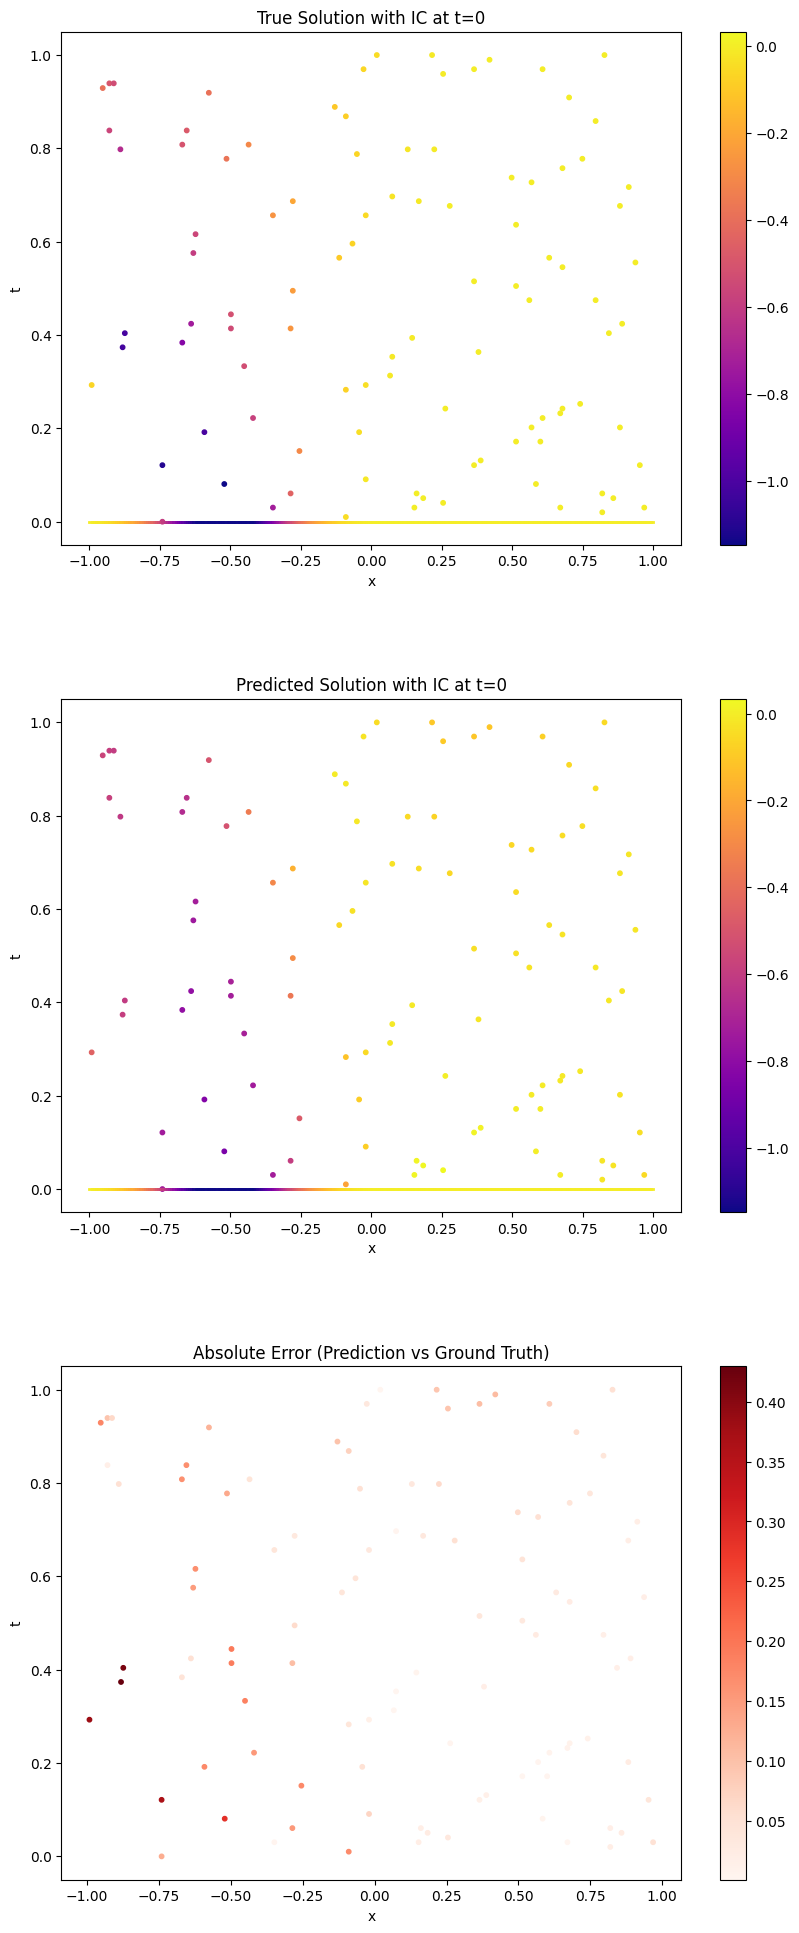

Generating extra dense test example for visualization...

Creating test dataloader
Test batches: 10 (batch_size: 100)


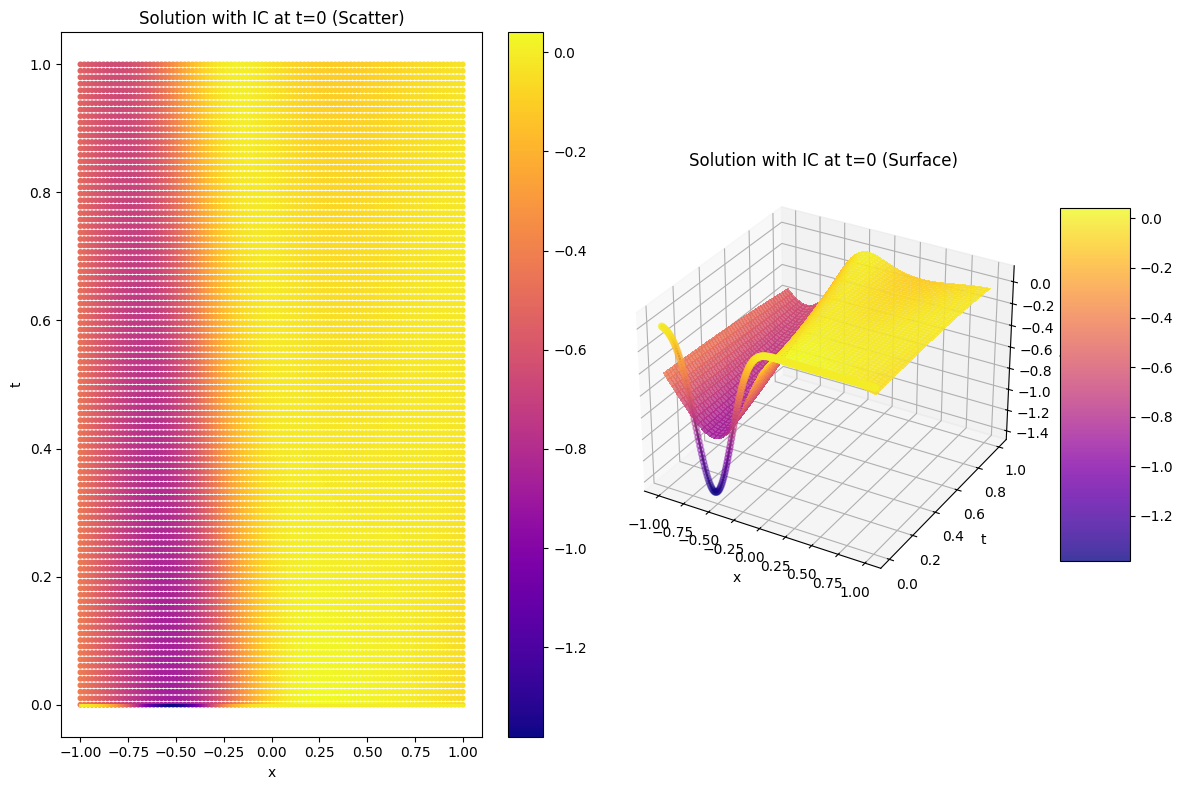

Dense test example plotted and saved.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.010844643227756023    │
│     test_relative_l2      │    0.3667459487915039     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.010844643227756023, 'test_relative_l2': 0.3667459487915039}]

In [30]:
# Test the model after training
trainer.test(model, datamodule=data_module)

# 🌟🚀 **DeepONet Competition** 🏆🔥  

### **🏅 Neural Operators Challenge**  

📢  We're forming teams to compete for the **best relative error** on **RD database**, located in *'data/Jaca25/RD-Comp.mat'* !  

**How it works:**  
- 👥 **Team Formation**: We'll build groups to collaborate  
- 🏋️ **Training Phase**: Optimize your DeepONet models  
- 🏁 **Competition**: Battle for the lowest relative error  
- 🎯 **Target**: Conquer both databases!  

🏅 **May the best model win!** 🏅  


<div style="font-family: 'Courier New', monospace; line-height: 1.5; color: #333; background-color: #f9f9f9; padding: 20px; border-radius: 10px; border-left: 5px solid #4285F4;">

<h2 style="color: #4285F4; border-bottom: 2px solid #EA4335; padding-bottom: 10px;"> <strong>DeepONet Training Script</strong> - Complete Argument Documentation </h2>

<div style="background: white; padding: 15px; border-radius: 8px; margin: 10px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
<h3 style="color: #EA4335;">🎛️ MODE CONTROL</h3>
<ul style="list-style-type: none; padding-left: 5px;">
  <li><strong>--train</strong> <span style="color: #34A853;">(flag)</span> →  Train the model (default mode)</li>
  <li style="padding-left: 20px; color: #555;"> Example: <code>--train</code></li>
  
  <li><strong>--test</strong> <span style="color: #34A853;">(flag)</span> →  Test the model with saved weights</li>
  <li style="padding-left: 20px; color: #555;"> Example: <code>--test</code></li>
  
  <li><strong>--pretrained</strong> <span style="color: #34A853;">(str)</span> →  Path to pre-trained model</li>
  <li style="padding-left: 20px; color: #555;"> Default: <code>None</code></li>
  <li style="padding-left: 20px; color: #555;"> Example: <code>--pretrained "checkpoints/last.ckpt"</code></li>
</ul>
</div>

<div style="background: white; padding: 15px; border-radius: 8px; margin: 10px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
<h3 style="color: #EA4335;">📊 DATA CONFIGURATION</h3>
<ul style="list-style-type: none; padding-left: 5px;">
  <li><strong>--data_path</strong> <span style="color: #34A853;">(str)</span> →  Path to .mat data file</li>
  <li style="padding-left: 20px; color: #555;"> Default: <code>'data/reaction_diffusion_dataset_N5000_P100_L0.20_100x100.mat'</code></li>
  <li style="padding-left: 20px; color: #555;"> Example: <code>--data_path "custom_data.mat"</code></li>
  
  <li><strong>--batch_size</strong> <span style="color: #34A853;">(int)</span> →  Training batch size</li>
  <li style="padding-left: 20px; color: #555;"> Default: <code>10000</code></li>
  <li style="padding-left: 20px; color: #555;"> Example: <code>--batch_size 5000</code></li>
</ul>
</div>

<div style="background: white; padding: 15px; border-radius: 8px; margin: 10px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
<h3 style="color: #EA4335;">🏗️ MODEL ARCHITECTURE</h3>
<ul style="list-style-type: none; padding-left: 5px;">
  <li><strong>--hidden_dim</strong> <span style="color: #34A853;">(int)</span> →  Hidden dimension size</li>
  <li style="padding-left: 20px; color: #555;"> Default: <code>50</code></li>
  <li style="padding-left: 20px; color: #555;"> Example: <code>--hidden_dim 100</code></li>
  
  <li><strong>--trunk_layers</strong> <span style="color: #34A853;">(int)</span> → 🌳 Number of trunk network layers</li>
  <li style="padding-left: 20px; color: #555;"> Default: <code>5</code></li>
  
  <li><strong>--branch_layers</strong> <span style="color: #34A853;">(int)</span> → 🌿 Number of branch network layers</li>
  <li style="padding-left: 20px; color: #555;"> Default: <code>5</code></li>
</ul>
</div>

<div style="background: white; padding: 15px; border-radius: 8px; margin: 10px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
<h3 style="color: #EA4335;">⚙️ TRAINING CONFIGURATION</h3>
<ul style="list-style-type: none; padding-left: 5px;">
  <li><strong>--max_epochs</strong> <span style="color: #34A853;">(int)</span> →  Maximum training epochs</li>
  <li style="padding-left: 20px; color: #555;"> Default: <code>1</code></li>
  <li style="padding-left: 20px; color: #555;"> Example: <code>--max_epochs 100</code></li>

  <li><strong>--lr</strong> <span style="color: #34A853;">(int)</span> →  Learning Rate</li>
  <li style="padding-left: 20px; color: #555;"> Default: <code>1.e-3</code></li>
  <li style="padding-left: 20px; color: #555;"> Example: <code>--lr 1.e-3</code></li>
</ul>
</div>

<div style="background: white; padding: 15px; border-radius: 8px; margin: 10px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
<h3 style="color: #EA4335;"> LOGGING & CHECKPOINTS</h3>
<ul style="list-style-type: none; padding-left: 5px;">
  <li><strong>--project</strong> <span style="color: #34A853;">(str)</span> →  W&B project name</li>
  <li style="padding-left: 20px; color: #555;"> Default: <code>'test'</code></li>
</ul>
</div>

<div style="background: white; padding: 15px; border-radius: 8px; margin: 10px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
<h3 style="color: #EA4335;"> HARDWARE SETTINGS</h3>
<ul style="list-style-type: none; padding-left: 5px;">
  <li><strong>--accelerator</strong> <span style="color: #34A853;">(str)</span> →  Hardware accelerator type</li>
  <li style="padding-left: 20px; color: #555;"> Default: <code>'auto'</code></li>
  <li style="padding-left: 20px; color: #555;"> Options: <code>cpu, gpu, tpu, auto</code></li>
  
  <li><strong>--devices</strong> <span style="color: #34A853;">(str)</span> →  Devices to use</li>
  <li style="padding-left: 20px; color: #555;"> Default: <code>'auto'</code></li>
</ul>
</div>

<div style="background: white; padding: 15px; border-radius: 8px; margin: 10px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
<h3 style="color: #EA4335;">🚀 EXAMPLE USAGE</h3>
<ol>
</div>

In [11]:
#Example

!python main.py --train --max_epochs 1 --data_path data/Jaca25/RD-tester.mat --hidden_dim 10 --trunk_layers 1 --branch_layers 1 --lr 1.e-5


Initializing DataModule with batch_size: 512, sampled: 100

Setting up DataModule for stage: fit

Loading data from data/Jaca25/RD-tester.mat for train split
Available keys in .mat file: ['__header__', '__version__', '__globals__', 'length_scale', 's_train', 't', 'u_train', 'x', 'y_train']

Original shapes before reshaping:
u_train shape: torch.Size([25000, 100]) (input functions)
y_train shape: torch.Size([25000, 2]) (coordinates)
s_train shape: torch.Size([25000, 1]) (solutions)

After reshaping to [Trajectories, Sampled, Features]:
u_train shape: torch.Size([250, 100, 100])
y_train shape: torch.Size([250, 100, 2])
s_train shape: torch.Size([250, 100, 1])

After selecting train split (200 trajectories):
u_train shape: torch.Size([200, 100, 100])
y_train shape: torch.Size([200, 100, 2])
s_train shape: torch.Size([200, 100, 1])

Final flattened shapes for train dataset:
Input functions (u) shape: torch.Size([20000, 100])
Coordinates (y) shape: torch.Size([20000, 2])
Solutions (s) shap